## Uniform Time Course process output comparisons

In [1]:
import sys
import os
from tempfile import mkdtemp

import numpy as np
from process_bigraph import Composite
from process_bigraph.experiments.parameter_scan import RunProcess


sys.path.insert(0, '..')


from biosimulator_processes.processes.amici_process import UtcAmici
from biosimulator_processes.processes.copasi_process import UtcCopasi

from biosimulator_processes.io import read_report_outputs
from biosimulator_processes.helpers import plot_utc_outputs, plot_ode_output_data

Smoldyn is not properly installed in this environment and thus its process implementation cannot be registered. Please consult smoldyn documentation.
Available processes:
[ 'console-emitter',
  'ram-emitter',
  'composite',
  'cobra-process',
  'copasi-process',
  'tellurium-process',
  'utc-amici',
  'utc-copasi',
  'copasi-step',
  'tellurium-step',
  'amici-step',
  'plotter',
  'plotter2d']


In [2]:
omex_dir = './examples/sbml-core/Elowitz-Nature-2000-Repressilator'
omex_fp = omex_dir + '.omex'
sbml_fp = os.path.join(omex_dir, 'BIOMD0000000012_url.xml')
sedml_fp = os.path.join(omex_dir, 'simulation.sedml')
reports_path = os.path.join(omex_dir, 'reports.h5')

Configure and create an Amici UTC instance using just the archive filepath.

In [3]:
utc_amici = UtcAmici(config={'model': {'model_source': omex_dir + '.omex'}})

2024-05-30 12:22:51.933 - amici.sbml_import - INFO - Finished importing SBML                         (3.74E-02s)
2024-05-30 12:22:51.979 - amici.sbml_import - INFO - Finished processing SBML observables            (4.35E-02s)
2024-05-30 12:22:51.983 - amici.sbml_import - INFO - Finished processing SBML event observables      (6.67E-07s)
2024-05-30 12:22:52.006 - amici.de_model - INFO - Finished computing xdot                            (3.25E-03s)
2024-05-30 12:22:52.012 - amici.de_model - INFO - Finished computing x0                              (2.71E-03s)
2024-05-30 12:22:52.030 - amici.de_model - INFO - Finished computing w                               (1.49E-02s)
2024-05-30 12:22:52.685 - amici.de_export - INFO - Finished generating cpp code                      (6.50E-01s)
2024-05-30 12:23:01.657 - amici.de_export - INFO - Finished compiling cpp code                       (8.97E+00s)


In [4]:
# t range parameters set via sedml introspection within archive contents:
utc_amici.t[0], utc_amici.t[-1], utc_amici.duration, utc_amici.step_size, utc_amici.num_steps

(0.0, 1000.0, 1000, 1.0, 600)

In [5]:
# you can verify this time config against the SEDML file
!cat ./examples/sbml-core/Elowitz-Nature-2000-Repressilator/simulation.sedml

<?xml version="1.0" encoding="UTF-8"?>
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version3" level="1" version="3"
  xmlns:sbml="http://www.sbml.org/sbml/level2/version3">
  <listOfModels>
    <model id="model" language="urn:sedml:language:sbml" source="BIOMD0000000012_url.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfSpecies/sbml:species[@id='PX']/@initialAmount" newValue="0"/>
      </listOfChanges>
    </model>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="simulation" initialTime="0" outputStartTime="400" outputEndTime="1000" numberOfPoints="600">
      <algorithm kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task" modelReference="model" simulationReference="simulation"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="data_gen_time" name="time">
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> var_time </ci>
      </ma

In [6]:
# run the amici utc simulation with the interface's update method:
amici_results = utc_amici.update()

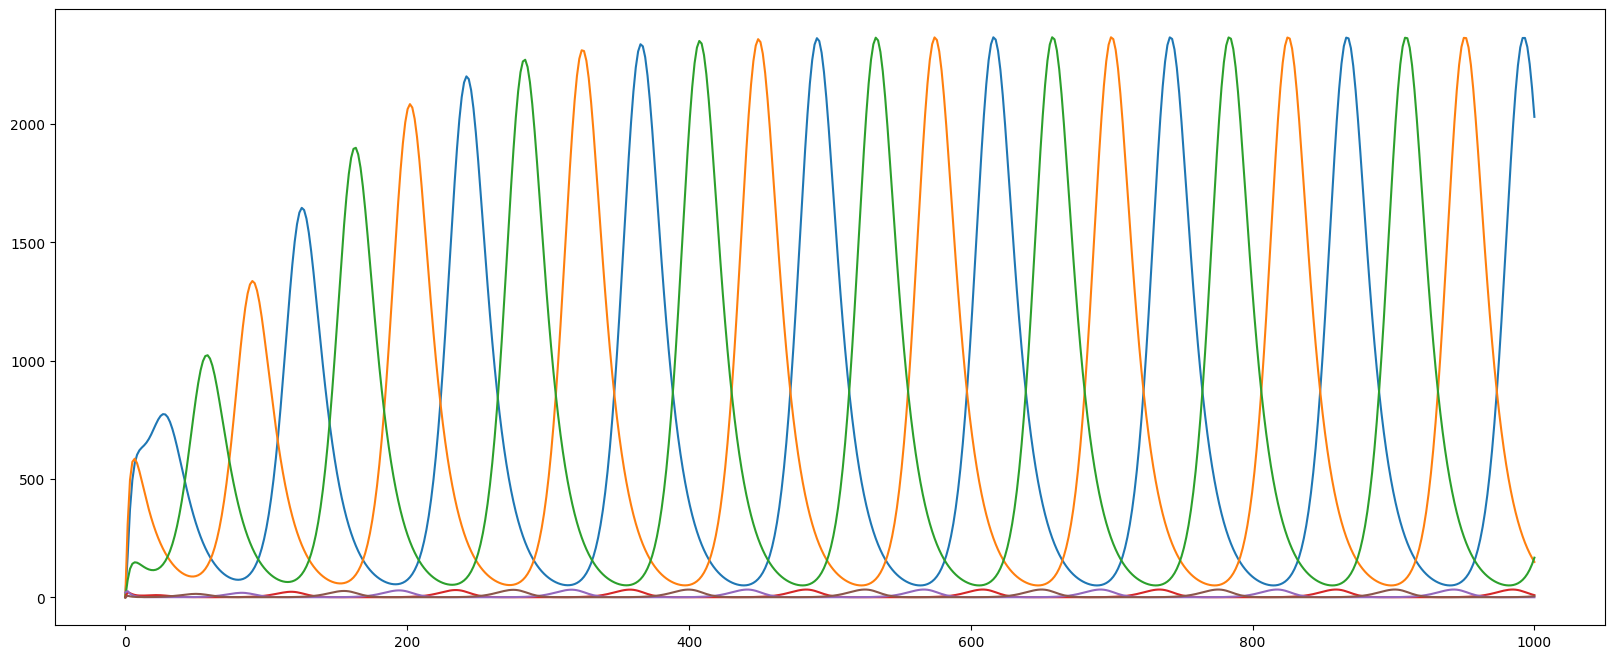

In [7]:
# use built-in plot to plot results
utc_amici.plot_results()

Create a `UtcTellurium` instance as above

In [8]:
from biosimulator_processes.processes.tellurium_process import UtcTellurium


utc_tellurium = UtcTellurium(config={'model': {'model_source': omex_dir + '.omex'}})

In [9]:
tellurium_results = utc_tellurium.update()

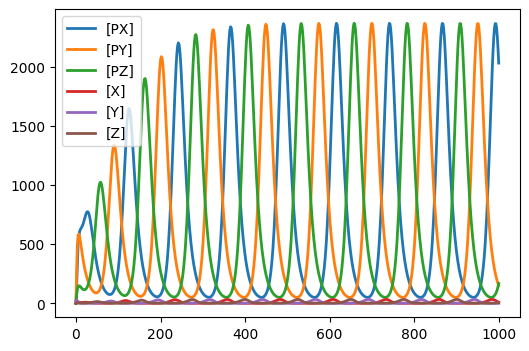

In [10]:
utc_tellurium.plot_results()

Create a `UtcCopasi` instance and run the same

In [11]:
utc_copasi = UtcCopasi(config={'model': {'model_source': omex_dir + '.omex'}})

In [12]:
copasi_results = utc_copasi.update()

<Axes: xlabel='Time'>

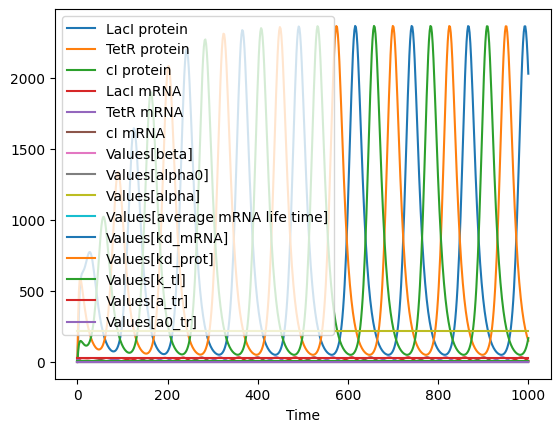

In [13]:
utc_copasi.plot_results()

Finally, optionally generate a "ground truth" which we include in the comparison. The default source for ground-truth data is via uploading an omex archive as model source. The report outputs must be included in the archive.

In [14]:
# Generate comparison matrix from ground truth
from biosimulator_processes.api.compare import generate_comparison
from biosimulator_processes.io import standardize_report_outputs

In [15]:
report_results = standardize_report_outputs(reports_path)

In [16]:
print(f"copasi result keys: {copasi_results['floating_species'].keys()}\nTellurium result keys: {tellurium_results['floating_species'].keys()}\nAmici Result keys: {amici_results['floating_species'].keys()}\nGround truth report keys: {report_results['floating_species'].keys()}")

copasi result keys: dict_keys(['PX', 'PY', 'PZ', 'X', 'Y', 'Z'])
Tellurium result keys: dict_keys(['PX', 'PY', 'PZ', 'X', 'Y', 'Z'])
Amici Result keys: dict_keys(['PX', 'PY', 'PZ', 'X', 'Y', 'Z'])
Ground truth report keys: dict_keys(['LacI protein', 'TetR protein', 'cI protein', 'LacI mRNA', 'TetR mRNA', 'cI mRNA'])


In [17]:
for spec_id in utc_tellurium.floating_species_list:
    outputs = [copasi_results['floating_species'][spec_id], amici_results['floating_species'][spec_id]]
    comparison = generate_comparison(
        outputs=outputs,
        simulators=['copasi', 'amici']
    )
    print(comparison)

ComparisonMatrix(data=        copasi  amici
copasi    True   True
amici     True   True, name=None, ground_truth=None)
ComparisonMatrix(data=        copasi  amici
copasi    True   True
amici     True   True, name=None, ground_truth=None)
ComparisonMatrix(data=        copasi  amici
copasi    True   True
amici     True   True, name=None, ground_truth=None)
ComparisonMatrix(data=        copasi  amici
copasi    True   True
amici     True   True, name=None, ground_truth=None)
ComparisonMatrix(data=        copasi  amici
copasi    True   True
amici     True   True, name=None, ground_truth=None)
ComparisonMatrix(data=        copasi  amici
copasi    True   True
amici     True   True, name=None, ground_truth=None)


In [18]:
# TODO: fit tellurium and copasi a la amici with t

In [19]:
utc_copasi.t.shape, copasi_results['floating_species']['PY'].shape, amici_results['floating_species']['PY'].shape, tellurium_results['floating_species']['PY'].shape

((599,), (600,), (600,), (600,))

In [20]:
utc_copasi._get_sedml_time_params(omex_dir)

{'duration': 1000,
 'num_steps': 599,
 'step_size': 1.0,
 'output_start_time': 400,
 'initial_time': 0}

In [21]:
utc_copasi.duration

1000